# **Universidad Central**

![UC](https://www.ucentral.edu.co/themes/ucentral/img/template/Universidad%20Central.png)

## **Maestría en Analítica de Datos**
## *Fundamentos De Estadística Para La Analítica de Datos*
## **Profesor**: Nelson Alirio Cruz Gutierrez Ph.D.
## **Estudiantes**: 

## -- Cristian Camilo Guevara Serrano
## -- Jennifer Alexandra Rodríguez Crespo 
## -- Stiven Leonardo Silva Castillo

## **Tarea con los datos de casas**


1. Ya tenemos los datos dividios en train y test, además de tener imputados los faltantes.

2. El conjunto de datos de entrenamiento lo vamos a dividir en 
- El 80% para entrenamiento
- El 20% para validación

3. En el conjunto de datos de entrenamiento, entrenar 5 modelos cada uno con 5,10,15,20,25 variables.

4. Cada modelo probarlo en el conjunto de validación, con el $R^2$ y seleccionan el más alto. (por ejemplo el de 25 variables)

5. Ese modelo es el que van a usar para el conjunto de datos de prueba. 

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats # libreria estadistica de Scipy
from sklearn.feature_selection import RFE # RFE es para seleccionar modelos
from sklearn.model_selection import train_test_split # para dividir la base en train y test 
from sklearn import linear_model # para modelo lineal
from sklearn.metrics import mean_squared_error, r2_score # para sacar las metricas 
import statsmodels.api as sm  ## Parte estadistica
from statsmodels.sandbox.regression.predstd import wls_prediction_std  ## Parte estadistica
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Punto 1 y 2

In [ ]:
url ="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Casas/train.csv"
train = pd.read_csv(url, index_col=0)
url ="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/Casas/test.csv"
test = pd.read_csv(url)

In [ ]:
X = train[["MSZoning", "LotFrontage", "LotArea", "Street", "YearBuilt", "MasVnrArea"]]
### Las dummies se deben hacer antes de entrenamiento y prueba
X = pd.get_dummies(X, drop_first=True)
Y = train["SalePrice"]

In [ ]:
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, train_size=0.8, random_state=20) ## Muestreo aleatorio simple
X_test.shape

(292, 9)

## KNN = k-nearest_neigbors

In [ ]:
imputer = KNNImputer(n_neighbors=2)

Modelo con todas las variables


In [ ]:
perdidos = train.isnull().sum().reset_index(name="Conteo").sort_values("Conteo", ascending=False)
perdidos["Prop"] =perdidos["Conteo"]/train.shape[0]
perdidos[perdidos["Prop"]>0.2]["index"].to_list()

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [ ]:
X = train.drop(["SalePrice",'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)
### Las dummies se deben hacer antes de entrenamiento y prueba
X = pd.get_dummies(X, drop_first=True)
Y = train["SalePrice"]

In [ ]:
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, train_size=0.8, random_state=20) ## Muestreo aleatorio simple
X_test.shape

(292, 232)

In [ ]:
X_train_imp = imputer.fit_transform(X_train)
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns, index=X_train.index)

# Punto 3 y 4

3. En el conjunto de datos de entrenamiento, entrenar 5 modelos cada uno con 5,10,15,20,25 variables.

4. Cada modelo probarlo en el conjunto de validación, con el $R^2$ y seleccionan el más alto. (por ejemplo el de 25 variables)

In [ ]:
def features_selection(number):

    #Selección de variables

    regresion = linear_model.LinearRegression()
    selector = RFE(regresion, n_features_to_select=number, step=1)
    selector = selector.fit(X_train_imp, Y_train)

    #Entrenamiento modelo base

    regresion_fs = linear_model.LinearRegression().fit(X_train_imp[X_train_imp.columns[selector.support_]], Y_train)
    Y_pred_train = regresion_fs.predict(X_train_imp[X_train_imp.columns[selector.support_]])

    #Metricas
    print("=="*30)
    print("Para",number,"variables las métricas son:")
    print("R2",np.round(r2_score(Y_train, Y_pred_train),2)*100, "%")
    print("MAPE",np.round(mean_absolute_percentage_error(Y_train, Y_pred_train),2)*100, "%")

    return np.round(r2_score(Y_train, Y_pred_train),2)*100, np.round(mean_absolute_percentage_error(Y_train, Y_pred_train),2)*100, list(X_train_imp.columns[selector.support_])

    

In [ ]:
variables_ls = []
r2_ls = []
mape_ls = []

number_features = [5,10,15,20,25]

for number in number_features:

    r2, mape, variables = features_selection(number)
    variables_ls.append(variables)
    r2_ls.append(r2)
    mape_ls.append(mape)


df_metrics = pd.DataFrame()
df_metrics['Cantidad'] = number_features
df_metrics['Variables'] = variables_ls
df_metrics['R2'] = r2_ls
df_metrics['MAPE'] = mape_ls


Para 5 variables las métricas son:
R2 43.0 %
MAPE 25.0 %
Para 10 variables las métricas son:
R2 55.00000000000001 %
MAPE 23.0 %
Para 15 variables las métricas son:
R2 64.0 %
MAPE 21.0 %
Para 20 variables las métricas son:
R2 69.0 %
MAPE 20.0 %
Para 25 variables las métricas son:
R2 71.0 %
MAPE 19.0 %


In [ ]:
df_metrics.sort_values(by = 'R2',ascending = False)

,Cantidad,Variables,R2,MAPE
4,25,"[Neighborhood_Crawfor, Neighborhood_NoRidge, N...",71.0,19.0
3,20,"[Neighborhood_Crawfor, Neighborhood_NoRidge, N...",69.0,20.0
2,15,"[Neighborhood_NoRidge, Neighborhood_StoneBr, C...",64.0,21.0
1,10,"[Neighborhood_NoRidge, RoofMatl_CompShg, RoofM...",55.0,23.0
0,5,"[RoofMatl_Membran, RoofMatl_Tar&Grv, RoofMatl_...",43.0,25.0


Se evidencia que el modelo con mejor desempeño es el de 25 variables, por lo cual se procede a utilizar esta cantidad de variables en el modelo.

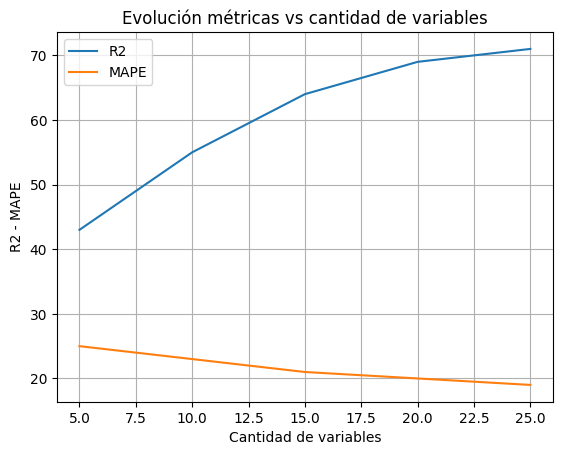

In [ ]:
df_metrics.plot(x = 'Cantidad', y = ['R2','MAPE'],title = 'Evolución métricas vs cantidad de variables', grid = True)
plt.xlabel('Cantidad de variables')
plt.ylabel('R2 - MAPE')
plt.show()

# Punto 5

Ese modelo es el que van a usar para el conjunto de datos de prueba. 

Inicialmente se ajustan los datos del test para hacer la prueba correspondiente

In [ ]:
imputer = KNNImputer(n_neighbors=2)
X_test_imp = imputer.fit_transform(X_test)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns, index=X_test.index)

Se estiman las 25 variables del mejor modelo

In [ ]:
#Se estiman las 25 variables
regresion = linear_model.LinearRegression()
selector_25 = RFE(regresion, n_features_to_select=25, step=1)
selector_25 = selector_25.fit(X_train_imp, Y_train)
X_train_imp.columns[selector_25.support_]

Index(['Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'Condition2_PosN', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_ImStucc',
       'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'BsmtExposure_Gd',
       'HeatingQC_Po', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA',
       'GarageQual_Fa', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po',
       'GarageCond_TA'],
      dtype='object')

Se entrena el mejor modelo

In [ ]:
best_model = linear_model.LinearRegression()
best_model.fit(X_train[X_train_imp.columns[selector_25.support_]],Y_train)

R2

In [ ]:
Y_pred_train = best_model.predict(X_train_imp[X_train_imp.columns[selector_25.support_]]) ### Entrenamiento
Y_pred_test = best_model.predict(X_test_imp[X_train_imp.columns[selector_25.support_]]) ## Prueba

print("R2 train",np.round(r2_score(Y_train, Y_pred_train),2)*100, "%")
print("R2 prueba",np.round(r2_score(Y_test, Y_pred_test),2)*100, "%")

R2 train 71.0 %
R2 prueba 61.0 %


Mape

In [ ]:
Y_pred_train=best_model.predict(X_train_imp[X_train_imp.columns[selector_25.support_]]) ### Entrenamiento
Y_pred_test=best_model.predict(X_test_imp[X_train_imp.columns[selector_25.support_]]) ## Prueba
print("MAPE train",np.round(mean_absolute_percentage_error(Y_train, Y_pred_train),2)*100, "%")
print("MAPE prueba",np.round(mean_absolute_percentage_error(Y_test, Y_pred_test),2)*100, "%")

MAPE train 19.0 %
MAPE prueba 21.0 %
